# Library Imports

In [ ]:
!pip3 install dython
!pip3 install scikit-learn
!pip3 install numpy
!pip3 install pandas
!pip3 install seaborn
!pip3 install scipy
!pip3 install tqdm
!pip3 install matplotlib

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm import trange
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from dython.nominal import associations
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency

# Data Loading

In [ ]:
# only run this chunk if you are running this in Collab and change the directory
# path to where the data is actually stored
# link to dataset to download: https://www.kaggle.com/competitions/nfl-big-data-bowl-2025/data
from google.colab import drive

drive.mount("/content/drive", force_remount=True)
%cd /content/drive/MyDrive/CS412_Project/

Mounted at /content/drive
/content/drive/MyDrive/CS412_Project


In [ ]:
plays_data = pd.read_csv("plays.csv", header=0)

# load modified plays data rather than the original
# plays_data = pd.read_csv("plays_modified.csv", header=0)

player_play_data = pd.read_csv("player_play.csv", header=0)

player_data = pd.read_csv("players.csv", header=0)

[-10  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7   8
   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26
  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44
  45  46  48  49  50  51  52  53  54  56  57  58  60  61  62  63  68  71
  74  75]


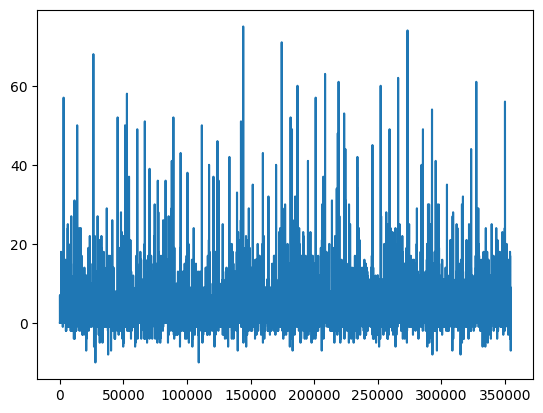

In [ ]:
print(np.sort(player_play_data['rushingYards'].unique()))

plt.plot(player_play_data['rushingYards'])

In [ ]:
plays_data.head()

,gameId,playId,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,...,yardsGained,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPointsAdded,isDropback,pff_runConceptPrimary,pff_runConceptSecondary,pff_runPassOption,pff_passCoverage,pff_manZone
0,2022102302,2655,(1:54) (Shotgun) J.Burrow pass short middle to...,3,1,10,CIN,ATL,CIN,21,...,9,0.004634,-0.004634,0.702717,True,NaN,NaN,0,Cover-3,Zone
1,2022091809,3698,(2:13) (Shotgun) J.Burrow pass short right to ...,4,1,10,CIN,DAL,CIN,8,...,4,0.002847,-0.002847,-0.240509,True,NaN,NaN,0,Quarters,Zone
2,2022103004,3146,(2:00) (Shotgun) D.Mills pass short right to D...,4,3,12,HOU,TEN,HOU,20,...,6,0.000205,-0.000205,-0.218480,True,NaN,NaN,0,Quarters,Zone
3,2022110610,348,(9:28) (Shotgun) P.Mahomes pass short left to ...,1,2,10,KC,TEN,TEN,23,...,4,-0.001308,0.001308,-0.427749,True,NaN,NaN,0,Quarters,Zone
4,2022102700,2799,(2:16) (Shotgun) L.Jackson up the middle to TB...,3,2,8,BAL,TB,TB,27,...,-1,0.027141,-0.027141,-0.638912,False,MAN,READ OPTION,0,Cover-1,Man


# Data Preprocessing

In [ ]:
# no need to run this if you loaded plays data as the modified play data
# run this to determine which quarterback played in each play
qbs = {player["nflId"]: player["displayName"] for _, player in player_data[player_data["position"] == "QB"].iterrows()}
game_play_qb = {str(game_play["gameId"])+str(game_play["playId"]): game_play["nflId"] for _, game_play in player_play_data.iterrows() if game_play["nflId"] in qbs.keys()}

In [ ]:
# no need to run this if you loaded plays data as the modified play data
# run this add the quarterback ID and name to their associaited play
plays_data["qb_Id"] = [game_play_qb[str(plays_data.iloc[i, 0])+str(plays_data.iloc[i, 1])] if str(plays_data.iloc[i, 0])+str(plays_data.iloc[i, 1]) in game_play_qb.keys() else None for i in range(len(plays_data))]
plays_data["qb_Name"] = [qbs[plays_data.iloc[i, 50]] if plays_data.iloc[i, 50] in qbs.keys() else None for i in range(len(plays_data))]

In [ ]:
# no need to run this if you loaded plays data as the modified play data
# run this to change the position on the field to a number between 1 - 99, with 99 being 1 yard away from a touchdown.
def get_field_position(row):
    if row['possessionTeam'] == row['yardlineSide']:
        return 100 - row['yardlineNumber']
    else:
        return row['yardlineNumber']

plays_data['fieldPosition'] = plays_data.apply(get_field_position, axis=1)

In [ ]:
# no need to run this if you loaded plays data as the modified play data
# run this to covert run or pass into 1 or 0 (1 if run and 0 if pass)
plays_data["playOption"] = [1 if eval == 1 else 0 for eval in plays_data["passLocationType"].isna()]

In [ ]:
# no need to run this if you loaded plays data as the modified play data
# remove features that are data collected after the snap and ids
plays_data = plays_data.drop(["gameId", "playId", "qb_Id", "playDescription",
                              "yardlineSide", "yardlineNumber", "passLocationType",
                              "playClockAtSnap", "passResult", "passLength",
                              "targetX", "targetY", "dropbackType", "dropbackDistance",
                              "playAction", "timeToThrow", "timeInTackleBox",
                              "timeToSack", "passTippedAtLine", "unblockedPressure",
                              "qbSpike", "qbKneel", "qbSneak", "rushLocationType",
                              "penaltyYards", "prePenaltyYardsGained", "yardsGained",
                              "homeTeamWinProbabilityAdded", "visitorTeamWinProbilityAdded",
                              "expectedPointsAdded", "isDropback", "pff_runConceptPrimary",
                              "pff_runConceptSecondary", "pff_runPassOption",
                              "pff_passCoverage", "pff_manZone", "playNullifiedByPenalty"], axis=1)

In [ ]:
# no need to run this if you loaded plays data as the modified play data
# run this to convert the game clock into seconds
plays_data["gameClock"] = [60*int(time.split(":")[0])+int(time.split(":")[1]) for time in plays_data["gameClock"]]

In [ ]:
# no need to run this if you loaded plays data as the modified play data
# save the cleaned data to reduce repeated data cleaning when rerunning the notebook
plays_data.to_csv("plays_modified.csv", index=False)

# Data Visualization and Feature Selection

### PCA Analysis

In [ ]:
categorical = ["possessionTeam", "defensiveTeam", "offenseFormation", "receiverAlignment", "qb_Name"]
numerical = [col for col in plays_data.columns if col not in categorical and col != "playOption"]

cat_imputer = SimpleImputer(strategy='constant', fill_value='NA')
encoder = OneHotEncoder(drop='first', sparse_output=False)

categorical_features = encoder.fit_transform(plays_data[categorical])
plays_data[categorical] = cat_imputer.fit_transform(plays_data[categorical])

x = np.hstack((plays_data[numerical].values, categorical_features))

scaler = StandardScaler()
scaled = scaler.fit_transform(x)

In [ ]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(scaled)

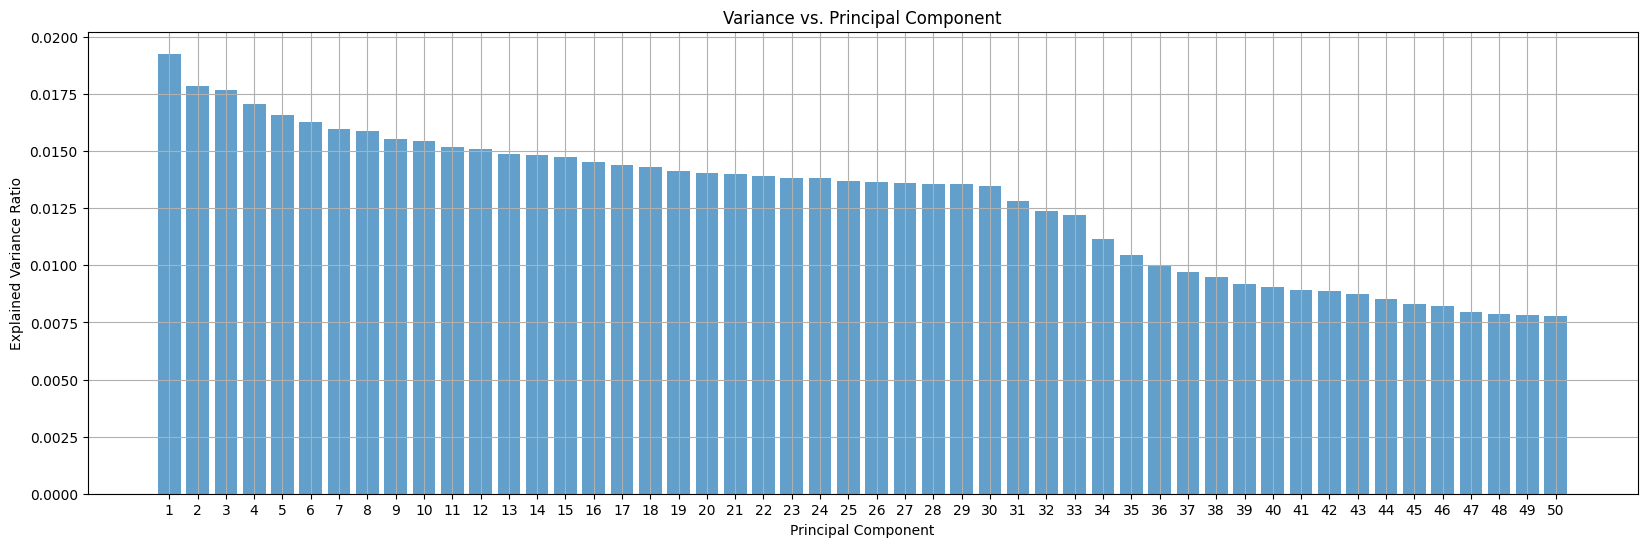

In [ ]:
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(20, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance vs. Principal Component')
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid()
plt.show()

### Class Imbalance Verification

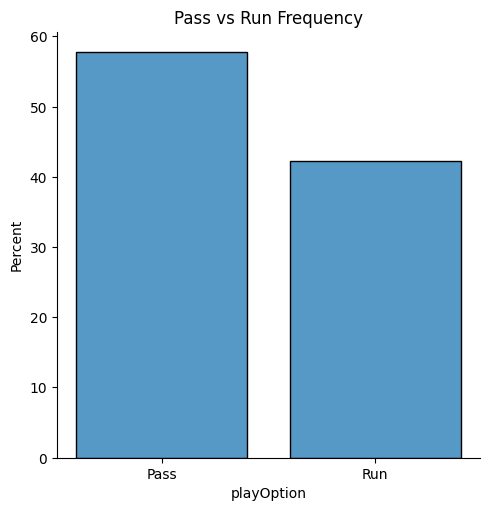

In [ ]:
sns.displot(plays_data['playOption'], discrete=True , shrink=0.8, stat='percent')
plt.xticks([0, 1], ['Pass', 'Run'])
plt.title('Pass vs Run Frequency')
plt.show()

From the plot above, we can see that although there are more passes than runs within the data, the disparity between the two classes is not large, so we can conclude there is not major imbalance.

### Feature Correlation

Create a heatmap to visualize the correlation between features.

Text(0.5, 1.0, 'Correlation Heatmap')

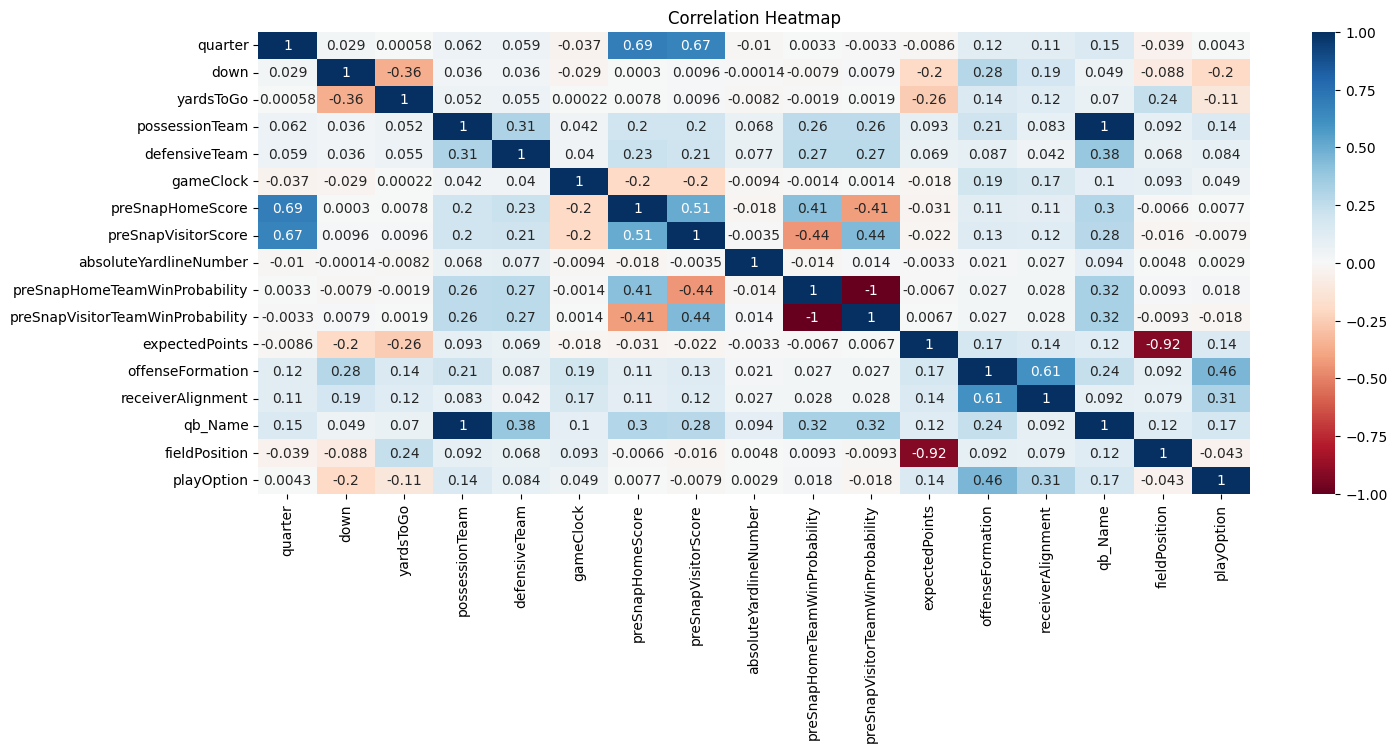

In [ ]:
plt.figure(figsize=(16, 6))
corr = associations(plays_data, compute_only=True)["corr"]
sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='RdBu')
plt.title("Correlation Heatmap")

Based on the correlation matrix, we can see that there appears to be some correlation between the features and the target feature (`playOption`).

### Numerical Feature Selection

However to ensure that the correlation is significant, we calculate p-values in order to extract the numerical features that are significant.

In [ ]:
numeric_cols = plays_data.select_dtypes(include='number').columns

p_values = pd.DataFrame(index=numeric_cols, columns=numeric_cols)

for col1 in numeric_cols:
    for col2 in numeric_cols:
        if col1 in numeric_cols and col2 in numeric_cols:
          corr, p = pearsonr(plays_data[col1], plays_data[col2])
          p_values.loc[col1, col2] = p
        else:
          p_values.loc[col1, col2] = np.nan

p_values

,quarter,down,yardsToGo,gameClock,preSnapHomeScore,preSnapVisitorScore,absoluteYardlineNumber,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,expectedPoints,fieldPosition,playOption
quarter,0.0,0.000224,0.941174,0.000002,0.0,0.0,0.183075,0.678856,0.678856,0.273308,0.000001,0.585736
down,0.000224,0.0,0.0,0.000234,0.969742,0.222358,0.985982,0.314742,0.314742,0.0,0.0,0.0
yardsToGo,0.941174,0.0,0.0,0.977608,0.323976,0.223432,0.300383,0.813894,0.813894,0.0,0.0,0.0
gameClock,0.000002,0.000234,0.977608,0.0,0.0,0.0,0.231129,0.859524,0.859524,0.022569,0.0,0.0
preSnapHomeScore,0.0,0.969742,0.323976,0.0,0.0,0.0,0.024636,0.0,0.0,0.000102,0.398959,0.326039
preSnapVisitorScore,0.0,0.222358,0.223432,0.0,0.0,0.0,0.654402,0.0,0.0,0.004852,0.04153,0.317002
absoluteYardlineNumber,0.183075,0.985982,0.300383,0.231129,0.024636,0.654402,0.0,0.075954,0.075954,0.675366,0.545311,0.712463
preSnapHomeTeamWinProbability,0.678856,0.314742,0.813894,0.859524,0.0,0.0,0.075954,0.0,0.0,0.391902,0.237819,0.019103
preSnapVisitorTeamWinProbability,0.678856,0.314742,0.813894,0.859524,0.0,0.0,0.075954,0.0,0.0,0.391902,0.237819,0.019103
expectedPoints,0.273308,0.0,0.0,0.022569,0.000102,0.004852,0.675366,0.391902,0.391902,0.0,0.0,0.0


In [ ]:
p_value_threshold = 0.05

sig_num = p_values["playOption"]
sig_num = list(sig_num[sig_num <= p_value_threshold].index)
sig_num.remove("playOption")
print(sig_num)

['down', 'yardsToGo', 'gameClock', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'expectedPoints', 'fieldPosition']


### Non-numerical Feature Selection

For non-numerical features, we perform a $\chi^2$ test between them and the target feature. Then derive the p-value of the test to determine their significance.

In [ ]:
categorical = ["possessionTeam", "defensiveTeam", "offenseFormation", "receiverAlignment", "qb_Name"]

p_value_threshold = 0.05

sig_cat = []

for feature in categorical:
  sub1 = pd.crosstab(index = plays_data["playOption"], columns = plays_data[feature])
  if chi2_contingency(sub1)[1] <= p_value_threshold:
    sig_cat.append(feature)

print(sig_cat)

['possessionTeam', 'defensiveTeam', 'offenseFormation', 'receiverAlignment', 'qb_Name']


# Data Splitting

In [ ]:
categorical = sig_cat
numerical = sig_num

In [ ]:
cat_imputer = SimpleImputer(strategy='constant', fill_value='NA')
plays_data[categorical] = cat_imputer.fit_transform(plays_data[categorical])

In [ ]:
encoder = OneHotEncoder(drop='first', sparse_output=False)
categorical_features = encoder.fit_transform(plays_data[categorical])

In [ ]:
y = plays_data["playOption"]
x = np.hstack((plays_data[numerical].values, categorical_features))

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.25, random_state=42)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Model Training/Tuning

### Logistic Regression

In [ ]:
log_reg = LogisticRegression(random_state=42, solver="sag", max_iter=1000)
log_reg.fit(train_x, train_y)

print("Train accuracy:", accuracy_score(train_y, log_reg.predict(train_x)))
print("Validation accuracy:", accuracy_score(val_y, log_reg.predict(val_x)))
print("Test accuracy:", accuracy_score(test_y, log_reg.predict(test_x)))

Train accuracy: 0.7238991110192268
Validation accuracy: 0.7238528317486564
Test accuracy: 0.7241379310344828


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### Decision Tree

In [ ]:
max_val = 0
max_i = 1

for i in trange(1, 51):

  dec_tree = DecisionTreeClassifier(random_state=42, max_depth=i)
  dec_tree.fit(train_x, train_y)

  if accuracy_score(val_y, dec_tree.predict(val_x)) > max_val:
    max_val = accuracy_score(val_y, dec_tree.predict(val_x))
    max_i = i

print("\nMax validation accuracy:", max_val, "\nAchieved at max depth:", max_i)

100%|██████████| 50/50 [00:24<00:00,  2.08it/s]


Max validation accuracy: 0.7317073170731707 
Achieved at max depth: 3


In [ ]:
dec_tree = DecisionTreeClassifier(random_state=42, max_depth=3)
dec_tree.fit(train_x, train_y)

print("Train accuracy:", accuracy_score(train_y, dec_tree.predict(train_x)))
print("Validation accuracy:", accuracy_score(val_y, dec_tree.predict(val_x)))
print("Test accuracy:", accuracy_score(test_y, dec_tree.predict(test_x)))

Train accuracy: 0.7272069464544139
Validation accuracy: 0.7317073170731707
Test accuracy: 0.7276110146365666


### Random Forest

In [ ]:
max_val = 0
max_i = 1

for i in trange(1, 51):

  rf = RandomForestClassifier(random_state=42, max_depth=i)
  rf.fit(train_x, train_y)

  if accuracy_score(val_y, rf.predict(val_x)) > max_val:
    max_val = accuracy_score(val_y, rf.predict(val_x))
    max_i = i

print("\nMax validation accuracy:", max_val, "\nAchieved at max depth:", max_i)

100%|██████████| 50/50 [01:55<00:00,  2.31s/it]


Max validation accuracy: 0.7408019842910294 
Achieved at max depth: 23


In [ ]:
max_val = 0
max_i = 1

for i in trange(1, 101):

  rf = RandomForestClassifier(random_state=42, max_depth=23, n_estimators=i)
  rf.fit(train_x, train_y)

  if accuracy_score(val_y, rf.predict(val_x)) > max_val:
    max_val = accuracy_score(val_y, rf.predict(val_x))
    max_i = i

print("\nMax validation accuracy:", max_val, "\nAchieved at forest size:", max_i)

100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


Max validation accuracy: 0.7412153782554775 
Achieved at forest size: 98


In [ ]:
rf = RandomForestClassifier(random_state=42, max_depth=23, n_estimators=98)
rf.fit(train_x, train_y)

print("Train accuracy:", accuracy_score(train_y, rf.predict(train_x)))
print("Validation accuracy:", accuracy_score(val_y, rf.predict(val_x)))
print("Test accuracy:", accuracy_score(test_y, rf.predict(test_x)))

Train accuracy: 0.8904279512094273
Validation accuracy: 0.7412153782554775
Test accuracy: 0.7335648722401389


### Ensemble

In [ ]:
ensemble = VotingClassifier(estimators=[('lr', log_reg), ('dt', dec_tree), ('rf', rf)], voting='soft', weights=[1,2,3])
ensemble.fit(train_x, train_y)

print("Train accuracy:", accuracy_score(train_y, ensemble.predict(train_x)))
print("Validation accuracy:", accuracy_score(val_y, ensemble.predict(val_x)))
print("Test accuracy:", accuracy_score(test_y, ensemble.predict(test_x)))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Train accuracy: 0.7754806698366756
Validation accuracy: 0.7350144687887556
Test accuracy: 0.7305879434383528


# Tuned Models Performance

Train, Val, and Test Performance

In [ ]:
models = [log_reg, dec_tree, rf, ensemble]

In [ ]:
perf1 = pd.DataFrame({
    'Train': [accuracy_score(train_y, model.predict(train_x)) for model in models],
    'Val': [accuracy_score(val_y, model.predict(val_x)) for model in models],
    'Test': [accuracy_score(test_y, model.predict(test_x)) for model in models]
}, index=["Logistic Regression", "Decision Tree", "Random Forest", "Ensemble"])
perf1

,Train,Val,Test
Logistic Regression,0.723899,0.723853,0.724138
Decision Tree,0.727207,0.731707,0.727611
Random Forest,0.890428,0.741215,0.733565
Ensemble,0.807008,0.733774,0.730588


5-Fold Cross Validated Accuracy Performance

In [ ]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

perf2 = pd.DataFrame({
    "Logistic Regression": cross_val_score(log_reg, x, y, cv=kf, scoring='accuracy'),
    "Decision Tree": cross_val_score(dec_tree, x, y, cv=kf, scoring='accuracy'),
    "Random Forest": cross_val_score(rf, x, y, cv=kf, scoring='accuracy'),
    "Ensemble": cross_val_score(ensemble, x, y, cv=kf, scoring='accuracy')
}, index=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"])
perf2.loc["Average"] = perf2.mean(axis=0)
perf2

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

,Logistic Regression,Decision Tree,Random Forest,Ensemble
Fold 1,0.727132,0.729922,0.732093,0.733643
Fold 2,0.732093,0.736744,0.742016,0.743876
Fold 3,0.733333,0.737054,0.750388,0.744806
Fold 4,0.714419,0.716279,0.724341,0.723721
Fold 5,0.715571,0.716811,0.722705,0.722395
Average,0.724509,0.727362,0.734308,0.733688


5-Fold Cross Validated Precision Performance

In [ ]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

perf3 = pd.DataFrame({
    "Logistic Regression": cross_val_score(log_reg, x, y, cv=kf, scoring='precision'),
    "Decision Tree": cross_val_score(dec_tree, x, y, cv=kf, scoring='precision'),
    "Random Forest": cross_val_score(rf, x, y, cv=kf, scoring='precision'),
    "Ensemble": cross_val_score(ensemble, x, y, cv=kf, scoring='precision')
}, index=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"])
perf3.loc["Average"] = perf3.mean(axis=0)
perf3

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

,Logistic Regression,Decision Tree,Random Forest,Ensemble
Fold 1,0.698523,0.699486,0.693061,0.699833
Fold 2,0.713911,0.717617,0.719092,0.722363
Fold 3,0.698585,0.702233,0.714171,0.708266
Fold 4,0.705255,0.703376,0.706202,0.707355
Fold 5,0.684864,0.686518,0.686804,0.688656
Average,0.700227,0.701846,0.703866,0.705295


5-Fold Cross Validated Recall Performance

In [ ]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

perf4 = pd.DataFrame({
    "Logistic Regression": cross_val_score(log_reg, x, y, cv=kf, scoring='recall'),
    "Decision Tree": cross_val_score(dec_tree, x, y, cv=kf, scoring='recall'),
    "Random Forest": cross_val_score(rf, x, y, cv=kf, scoring='recall'),
    "Ensemble": cross_val_score(ensemble, x, y, cv=kf, scoring='recall')
}, index=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"])
perf4.loc["Average"] = perf4.mean(axis=0)
perf4

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

,Logistic Regression,Decision Tree,Random Forest,Ensemble
Fold 1,0.601346,0.611070,0.635004,0.626028
Fold 2,0.603104,0.614191,0.631929,0.632668
Fold 3,0.627524,0.635004,0.663426,0.653702
Fold 4,0.604504,0.615764,0.641098,0.636172
Fold 5,0.607038,0.608504,0.633431,0.627566
Average,0.608703,0.616906,0.640977,0.635227


5-Fold Cross Validated F1 Performance

In [ ]:
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

perf5 = pd.DataFrame({
    "Logistic Regression": cross_val_score(log_reg, x, y, cv=kf, scoring='f1'),
    "Decision Tree": cross_val_score(dec_tree, x, y, cv=kf, scoring='f1'),
    "Random Forest": cross_val_score(rf, x, y, cv=kf, scoring='f1'),
    "Ensemble": cross_val_score(ensemble, x, y, cv=kf, scoring='f1')
}, index=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"])
perf5.loc["Average"] = perf5.mean(axis=0)
perf5

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which 

,Logistic Regression,Decision Tree,Random Forest,Ensemble
Fold 1,0.646302,0.652295,0.662763,0.660876
Fold 2,0.653846,0.661888,0.672699,0.674547
Fold 3,0.661151,0.666929,0.687864,0.679891
Fold 4,0.651004,0.656660,0.672077,0.669878
Fold 5,0.643607,0.645161,0.659039,0.656694
Average,0.651182,0.656587,0.670888,0.668377
